In [1]:
""" Created on February 16, 2023 // @author: Sarah Shi """

import numpy as np
import pandas as pd
import scipy

import os
import sys
import copy
import time
import random
import warnings

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
from torch.nn.modules.activation import LeakyReLU, Sigmoid
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

sys.path.append('src')
import MIN_ML as mm

import concurrent.futures
from multiprocessing import freeze_support
import itertools 

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('font',**{'family':'Avenir', 'size': 20})
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def save_model(model, optimizer, path):
    check_point = {'params': model.state_dict(),                            
                   'optimizer': optimizer.state_dict()}
    torch.save(check_point, path)

def save_model_nn(model, optimizer, path, best_model_state):
    check_point = {'params': best_model_state,                            
                   'optimizer': optimizer.state_dict()},
    torch.save(check_point, path)

def load_model(model, optimizer=None, path=''):
    check_point = torch.load(path)
    model.load_state_dict(check_point['params'])
    if optimizer is not None:
        optimizer.load_state_dict(check_point['optimizer'])

def getLatent(model, dataset:np):
    #transform real data to latent space using the trained model
    latents=[]
    model.to(device)

    dataset_ = FeatureDataset(dataset)
    loader = DataLoader(dataset_,batch_size=20,shuffle=False)
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader):
            x = data.to(device)
            z = model.encoded(x)
            latents.append(z.detach().cpu().numpy())
    
    return np.concatenate(latents, axis=0)

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
class LabelDataset(Dataset):
    def __init__(self, x, labels):
        if len(x.shape)==2:
            self.x = torch.from_numpy(x).type(torch.FloatTensor)
            self.labels = torch.from_numpy(labels).type(torch.LongTensor)
        else:
            self.x = x.reshape(-1, x.shape[-1]) #dataset keeps the right shape for training
            self.labels = labels

    def __len__(self):
        return len(self.x) 
    
    def __getitem__(self, n): 
        return self.x[n], self.labels[n]


class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim=10, classes=17, dropout_rate=0.1, hidden_layer_sizes=[8]):
        super(MultiClassClassifier, self).__init__()
        self.input_dim = input_dim
        self.classes = classes
        self.dropout_rate = dropout_rate
        self.hls = hidden_layer_sizes

        def element(in_channel, out_channel, is_last=False):
            layers = [
                nn.Linear(in_channel, out_channel),
                nn.BatchNorm1d(out_channel),  # Add batch normalization
                nn.LeakyReLU(0.02),
            ]
            if not is_last:
                layers.append(nn.Dropout(self.dropout_rate))  # Add dropout
            return layers

        if len(self.hls) == 1:
            encoder = element(self.input_dim, self.hls[0], is_last=True)
            encoder += [nn.Linear(self.hls[-1], classes)]
        else:
            encoder = element(self.input_dim, self.hls[0])
            for i in range(len(self.hls) - 1):
                is_last = (i == len(self.hls) - 2)
                encoder += element(self.hls[i], self.hls[i + 1], is_last)
            encoder += [nn.Linear(self.hls[-1], classes)]

        self.encode = nn.Sequential(*encoder)
        self.apply(weights_init)

    def encoded(self, x):
        return self.encode(x)

    def forward(self, x):
        en = self.encoded(x)
        return en

    def predict(self, x):
        # Get predicted scores
        scores = self.encoded(x)
        # Get predicted class indices
        class_indices = scores.argmax(dim=1)
        return class_indices


def train_nn(model, optimizer, label, train_loader, test_loader, n_epoch, criterion, patience=10):
    """
    Train a neural network using early stopping.

    Args:
        model: a PyTorch model
        optimizer: a PyTorch optimizer
        label: a string representing the type of labels being used
        train_loader: a PyTorch DataLoader for the training set
        test_loader: a PyTorch DataLoader for the validation set
        n_epoch: the maximum number of epochs to train for
        criterion: the loss function to optimize
        patience: the number of epochs to wait before stopping if the validation loss does not improve

    Returns:
        train_output: the final output of the model on the training set
        test_output: the final output of the model on the validation set
        avg_train_loss: a list of average training losses for each epoch
        avg_test_loss: a list of average validation losses for each epoch
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    avg_train_loss = []
    avg_test_loss = []
    best_test_loss = float('inf')
    best_model_state = None
    best_epoch = 0
    patience_counter = 0

    for epoch in range(n_epoch):
        # Training
        model.train()
        t = time.time()
        train_loss = []
        for i, (data, labels) in enumerate(train_loader):
            x = data.to(device)
            y = labels.to(device)
            train_output = model(x)
            loss = criterion(train_output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.detach().item())
        
        # Validation
        model.eval()
        test_loss = []
        with torch.no_grad():
            for i, (data, labels) in enumerate(test_loader):
                x = data.to(device)
                y = labels.to(device)
                test_output = model(x)
                loss = criterion(test_output, y)
                test_loss.append(loss.detach().item())

        # Logging
        avg_train = sum(train_loss) / len(train_loss)
        avg_test = sum(test_loss) / len(test_loss)
        avg_train_loss.append(avg_train)
        avg_test_loss.append(avg_test)
        
        training_time = time.time() - t
 
        print(f'[{epoch+1:03}/{n_epoch:03}] train_loss: {avg_train:.6f}, test_loss: {avg_test:.6f}, time: {training_time:.2f} s')

        # Early stopping
        if avg_test < best_test_loss:
            best_test_loss = avg_test
            best_epoch = epoch
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())  # Save the best model weights

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Validation loss hasn't improved for {patience} epochs. Stopping early.")
                break

    return train_output, test_output, avg_train_loss, avg_test_loss, best_model_state


def balance(train_data_x, train_data_y):

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)

    # Resample the dataset
    x_balanced, y_balanced = oversample.fit_resample(train_data_x, train_data_y)

    df_resampled = pd.DataFrame(x_balanced)
    df_resampled['Mineral'] = y_balanced

    df_balanced = pd.DataFrame()
    for class_label in df_resampled['Mineral'].unique():
        df_class = df_resampled[df_resampled['Mineral'] == class_label]
        df_balanced = pd.concat([df_balanced, df_class.sample(n=1000, replace = True, random_state=42)])

    # Reset the index of the balanced dataframe
    df_balanced = df_balanced.reset_index(drop=True)
    train_data_x = df_balanced.iloc[:, :-1].to_numpy()
    train_data_y = df_balanced.iloc[:, -1].to_numpy()

    return train_data_x, train_data_y


def neuralnetwork(df, name, hls, lr, wd, dr, ep, n, balanced): 

    path_beg = os.getcwd() + '/'
    output_dir = ["nn_parametermatrix", "autoencoder_parametermatrix"] 
    for ii in range(len(output_dir)):
        if not os.path.exists(path_beg + output_dir[ii]):
            os.makedirs(path_beg + output_dir[ii], exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
    label = ['Mineral']

    min = df[label]
    wt = df[oxides].fillna(0).to_numpy()

    ss = StandardScaler()
    array_norm = ss.fit_transform(wt)

    code = pd.Categorical(df['Mineral']).codes
    cat_lab = pd.Categorical(df['Mineral'])

    #split the dataset into train and test sets
    train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(array_norm, code, test_size=n, stratify = code, random_state=42)

    if balanced == True: 
        train_data_x, train_data_y = balance(train_data_x, train_data_y)

    #define datasets to be used with PyTorch - see autoencoder file for details
    feature_dataset = LabelDataset(train_data_x, train_data_y)
    test_dataset = LabelDataset(test_data_x, test_data_y)

    mapping = dict(zip(code, cat_lab))
    sort_mapping= dict(sorted(mapping.items(), key=lambda item: item[0])) 

    #autoencoder params:
    lr = lr
    wd = wd 
    dr = dr
    epochs = epochs
    batch_size = 256
    input_size = len(feature_dataset.__getitem__(0)[0])

    #define data loaders
    feature_loader = DataLoader(feature_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    np.savez('nn_parametermatrix/' + name + '_nn_features.npz', feature_loader = feature_loader, test_loader = test_loader)

    # Initialize model
    model = MultiClassClassifier(input_dim=input_size, dropout_rate = dr, hidden_layer_sizes=hidden_layer_sizes).to(device) # dropout_rate = dr

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(model.parameters(), lr=lr, weight_decay = wd)

    #train model using pre-defined function
    train_output, test_output, train_loss, test_loss, best_model_state = train_nn(model, optimizer, label, feature_loader, test_loader, epochs, criterion)
    np.savez('nn_parametermatrix/' + name + '_nn_loss.npz', train_loss = train_loss, test_loss = test_loss)
    
    model_path = 'nn_parametermatrix/' + name + "_nn_params.pt"
    save_model_nn(model, optimizer, model_path, best_model_state)

    # predict classes for entire training and test datasets
    train_pred_classes = model.predict(feature_dataset.x)
    test_pred_classes = model.predict(test_dataset.x)

    # calculate classification metrics
    train_report = classification_report(train_data_y, train_pred_classes, target_names = sort_mapping.values(), zero_division=0)
    test_report = classification_report(test_data_y, test_pred_classes, target_names = sort_mapping.values(), zero_division=0)

    return train_pred_classes, test_pred_classes, train_report, test_report, best_model_state

In [4]:
def nested_cv(df, name, hls, lr, wd, ep, n_splits_outer, n_splits_inner):

    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
    label = ['Mineral']

    code = pd.Categorical(df['Mineral']).codes
    cat_lab = pd.Categorical(df['Mineral'])

    X = df[oxides].fillna(0).to_numpy()
    y = code 
    
    mapping = dict(zip(code, cat_lab))
    sort_mapping = dict(sorted(mapping.items(), key=lambda item: item[0])) 

    outer_cv = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=42)

    train_reports = []
    test_reports = []
    reports_dict = {}  # Create a dictionary to store train and test reports for each trial

    log_file = 'nn_parametermatrix/training.log'

    outer_loop_count = 0

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
    
    X_train, y_train = balance(X_train, y_train)

    nn_count = 0 
    best_val_score = 0
    best_hls = None
    best_learning_rate = None
    best_weight_decay = None
    best_epochs = None 

    param_combinations = list(itertools.product(hidden_layer_sizes, learning_rates, weight_decays, epochs))

    for nn_count, (hls, lr, wd, ep) in enumerate(param_combinations):
        params_list = [
            (train_inner_idx, test_inner_idx, df, X_train, y_train, name, hls, lr, wd, ep)
            for train_inner_idx, test_inner_idx in inner_cv.split(X_train, y_train)
        ]

        message = f'[{nn_count:03}] hls: {hls}, lr: {lr}, wd: {wd}, ep: {ep}'
        with open(log_file, 'a') as f:
            f.write(message + '\n')

        with concurrent.futures.ThreadPoolExecutor() as executor:
            val_scores = list(executor.map(parallel_inner_loop, params_list))

        avg_val_score = np.mean(val_scores)

        if avg_val_score > best_val_score:
            best_val_score = avg_val_score
            best_hls = hls
            best_learning_rate = lr
            best_weight_decay = wd
            best_epochs = ep

    train_pred_classes, test_pred_classes, train_report, test_report = neuralnetwork_kfold(df, X_train, y_train, X_test, y_test, name, best_hls, best_learning_rate, best_weight_decay, best_epochs)

    reports_dict[f'{outer_loop_count}_{nn_count}'] = {
        'avg_train_report': train_report, 'avg_test_report': test_report, 'hls': best_hls,
        'lr': best_learning_rate, 'wd': best_weight_decay, 'ep': best_epochs}

    outer_loop_count += 1

    train_reports.append({
        'true_labels': y_train, 'predicted_labels': train_pred_classes, 'label_names': list(sort_mapping.values())})
    
    test_reports.append({
        'true_labels': y_test, 'predicted_labels': test_pred_classes,'label_names': list(sort_mapping.values())})

    avg_train_report = average_classification_reports(train_reports)
    avg_test_report = average_classification_reports(test_reports)

    best_params = np.array([best_hls, best_learning_rate, best_weight_decay, best_epochs])

    return reports_dict, train_reports, test_reports, avg_train_report, avg_test_report, best_params


def parallel_inner_loop(args):

    train_inner_idx, test_inner_idx, df, X_train, y_train, name, hls, lr, wd, ep = args
    X_train_inner, X_test_inner = X_train[train_inner_idx], X_train[test_inner_idx]
    y_train_inner, y_test_inner = y_train[train_inner_idx], y_train[test_inner_idx]

    train_pred_classes_inner, test_pred_classes_inner, _, _ = neuralnetwork_kfold(df, X_train_inner, y_train_inner, X_test_inner, y_test_inner, name, hls, lr, wd, ep)

    val_f1_score = f1_score(y_test_inner, test_pred_classes_inner, average='weighted')

    return val_f1_score


def neuralnetwork_kfold(df, X_train, y_train, X_test, y_test, name, hls, lr, wd, ep): 

    path_beg = os.getcwd() + '/'
    output_dir = ["nn_parametermatrix", "autoencoder_parametermatrix"] 
    for ii in range(len(output_dir)):
        if not os.path.exists(path_beg + output_dir[ii]):
            os.makedirs(path_beg + output_dir[ii], exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
    label = ['Mineral']

    ss = StandardScaler()
    array_norm_train = ss.fit_transform(X_train)
    array_norm_test = ss.transform(X_test)

    code = pd.Categorical(df['Mineral']).codes
    cat_lab = pd.Categorical(df['Mineral'])

    #define datasets to be used with PyTorch - see autoencoder file for details
    feature_dataset = LabelDataset(array_norm_train, y_train)
    test_dataset = LabelDataset(array_norm_test, y_test)

    mapping = dict(zip(code, cat_lab))
    sort_mapping= dict(sorted(mapping.items(), key=lambda item: item[0])) 

    #autoencoder params:
    lr = lr
    wd = wd 
    batch_size = 256
    epochs = ep
    hls = hls
    input_size = len(feature_dataset.__getitem__(0)[0])
    dr = 0.2

    #define data loaders
    feature_loader = DataLoader(feature_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    np.savez('nn_parametermatrix/' + name + '_nn_features.npz', feature_loader = feature_loader, test_loader = test_loader)

    # Initialize model
    model = MultiClassClassifier(input_dim=input_size, dropout_rate = dr, hidden_layer_sizes=hls).to(device) # dropout_rate = dr

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(model.parameters(), lr=lr, weight_decay = wd)

    #train model using pre-defined function
    train_output, test_output, train_loss, test_loss, best_model_state = train_nn(model, optimizer, label, feature_loader, test_loader, epochs, criterion)
    np.savez('nn_parametermatrix/' + name + '_nn_loss.npz', train_loss = train_loss, test_loss = test_loss)
    
    model_path = 'nn_parametermatrix/' + name + "_nn_params.pt"
    save_model_nn(model, optimizer, model_path, best_model_state)

    # predict classes for entire training and test datasets
    train_pred_classes = model.predict(feature_dataset.x)
    test_pred_classes = model.predict(test_dataset.x)

    # calculate classification metrics
    train_report = classification_report(train_data_y, train_pred_classes, target_names = sort_mapping.values(), zero_division=0)
    test_report = classification_report(test_data_y, test_pred_classes, target_names = sort_mapping.values(), zero_division=0)

    return train_pred_classes, test_pred_classes, train_report, test_report, best_model_state


# Define a function to average classification reports
def average_classification_reports(reports):
    metrics = []
    
    for report in reports:
        precision, recall, fscore, _ = precision_recall_fscore_support(
            report['true_labels'],
            report['predicted_labels'],
            average=None
        )
        metrics.append(np.array([precision, recall, fscore]))

    # Calculate the mean values of precision, recall, and F1-score
    avg_metrics = np.mean(metrics, axis=0)

    # Create a DataFrame to store the results
    avg_report_df = pd.DataFrame(
        avg_metrics.T,
        columns=['precision', 'recall', 'fscore'],
        index=reports[0]['label_names']
    )

    return avg_report_df

In [5]:
min_df = pd.read_csv('Training_Data/mindf_filt.csv')
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
label = ['Mineral']

min = min_df[label]
wt = min_df[oxides].fillna(0).to_numpy()

ss = StandardScaler()
array_norm = ss.fit_transform(wt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
mm.same_seeds(42)

lr = 5e-3 #5e-3
wd = 1e-4
dr = 0.15 # 0.25
n = 0.20
epochs = 500
# name = 'nn_wd_64_32_20percent'
name = 'nkcv'

start_time = time.time()

hls = [6] # 64, 32


lepr = pd.read_csv('Validation_Data/lepr_allphases_lim.csv', index_col=0)
lepr_df = lepr.dropna(subset=oxides, thresh = 5)

lepr_df = lepr_df[(lepr_df.Mineral!=np.nan)&(lepr_df.Mineral!='FeTiOxide')]
data_idx = np.arange(len(lepr_df))
train_idx, test_idx = train_test_split(data_idx, test_size=0.5, stratify=pd.Categorical(lepr_df['Mineral']).codes, random_state=42, shuffle=True)
lepr_df_lim = lepr_df.iloc[test_idx]

df_concat = pd.concat([min_df, lepr_df_lim])

train_pred_classes, test_pred_classes, train_report, test_report, best_model_state = mm.neuralnetwork(df_concat, name, mm.MultiClassClassifier, hls, lr, wd, dr, epochs, n, balanced = True) 
# train_pred_classes, test_pred_classes, train_report, test_report, best_model_state = mm.neuralnetwork(min_df, name, mm.MultiClassClassifier, hls, lr, wd, dr, epochs, n, balanced = True) 
print(name + " done! Time: " + str(time.time() - start_time) + "s")

[001/500] train_loss: 2.915041, test_loss: 2.837034, time: 0.48 s
[002/500] train_loss: 2.832694, test_loss: 2.747720, time: 0.25 s
[003/500] train_loss: 2.768581, test_loss: 2.677540, time: 0.18 s
[004/500] train_loss: 2.709350, test_loss: 2.622821, time: 0.18 s
[005/500] train_loss: 2.657182, test_loss: 2.547955, time: 0.17 s
[006/500] train_loss: 2.605711, test_loss: 2.509368, time: 0.18 s
[007/500] train_loss: 2.557065, test_loss: 2.446028, time: 0.18 s
[008/500] train_loss: 2.511634, test_loss: 2.394944, time: 0.19 s
[009/500] train_loss: 2.465631, test_loss: 2.341604, time: 0.24 s
[010/500] train_loss: 2.422156, test_loss: 2.308956, time: 0.18 s
[011/500] train_loss: 2.379743, test_loss: 2.308767, time: 0.16 s
[012/500] train_loss: 2.339889, test_loss: 2.224031, time: 0.17 s
[013/500] train_loss: 2.301312, test_loss: 2.206943, time: 0.19 s
[014/500] train_loss: 2.264025, test_loss: 2.165888, time: 0.17 s
[015/500] train_loss: 2.228147, test_loss: 2.149738, time: 0.24 s
[016/500] 

meta NOT subset; don't know how to subset; dropped


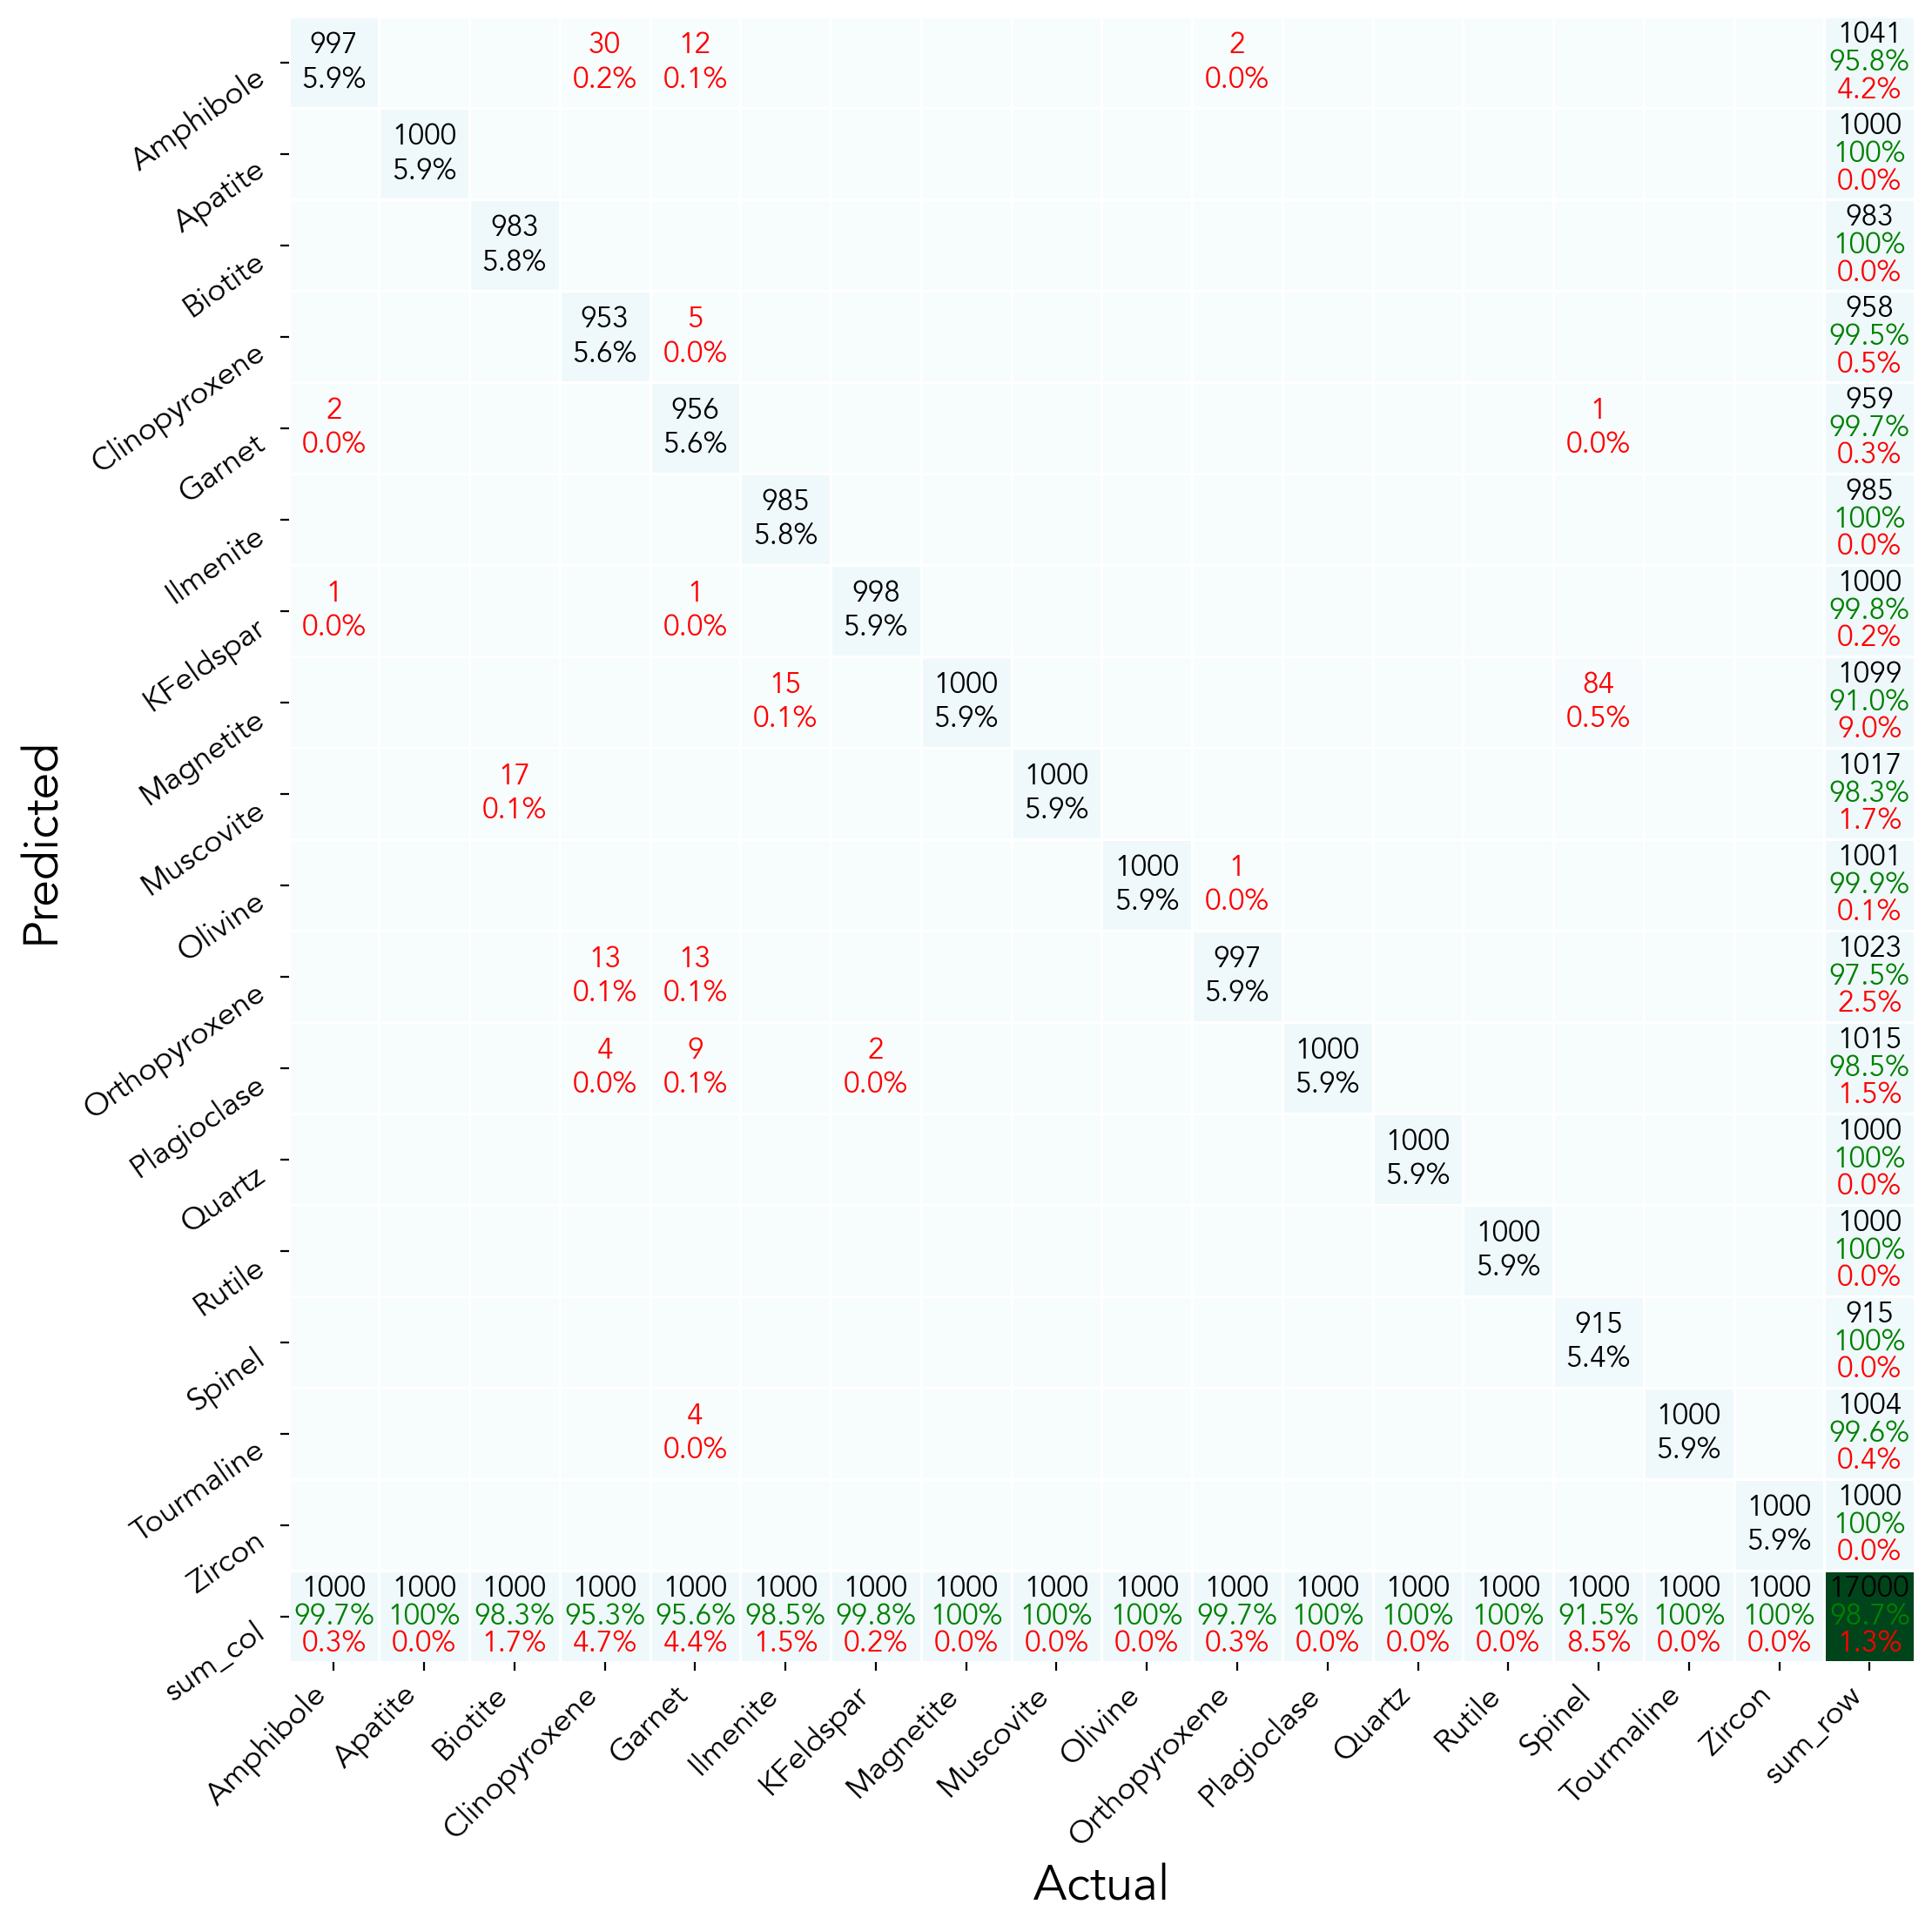

meta NOT subset; don't know how to subset; dropped


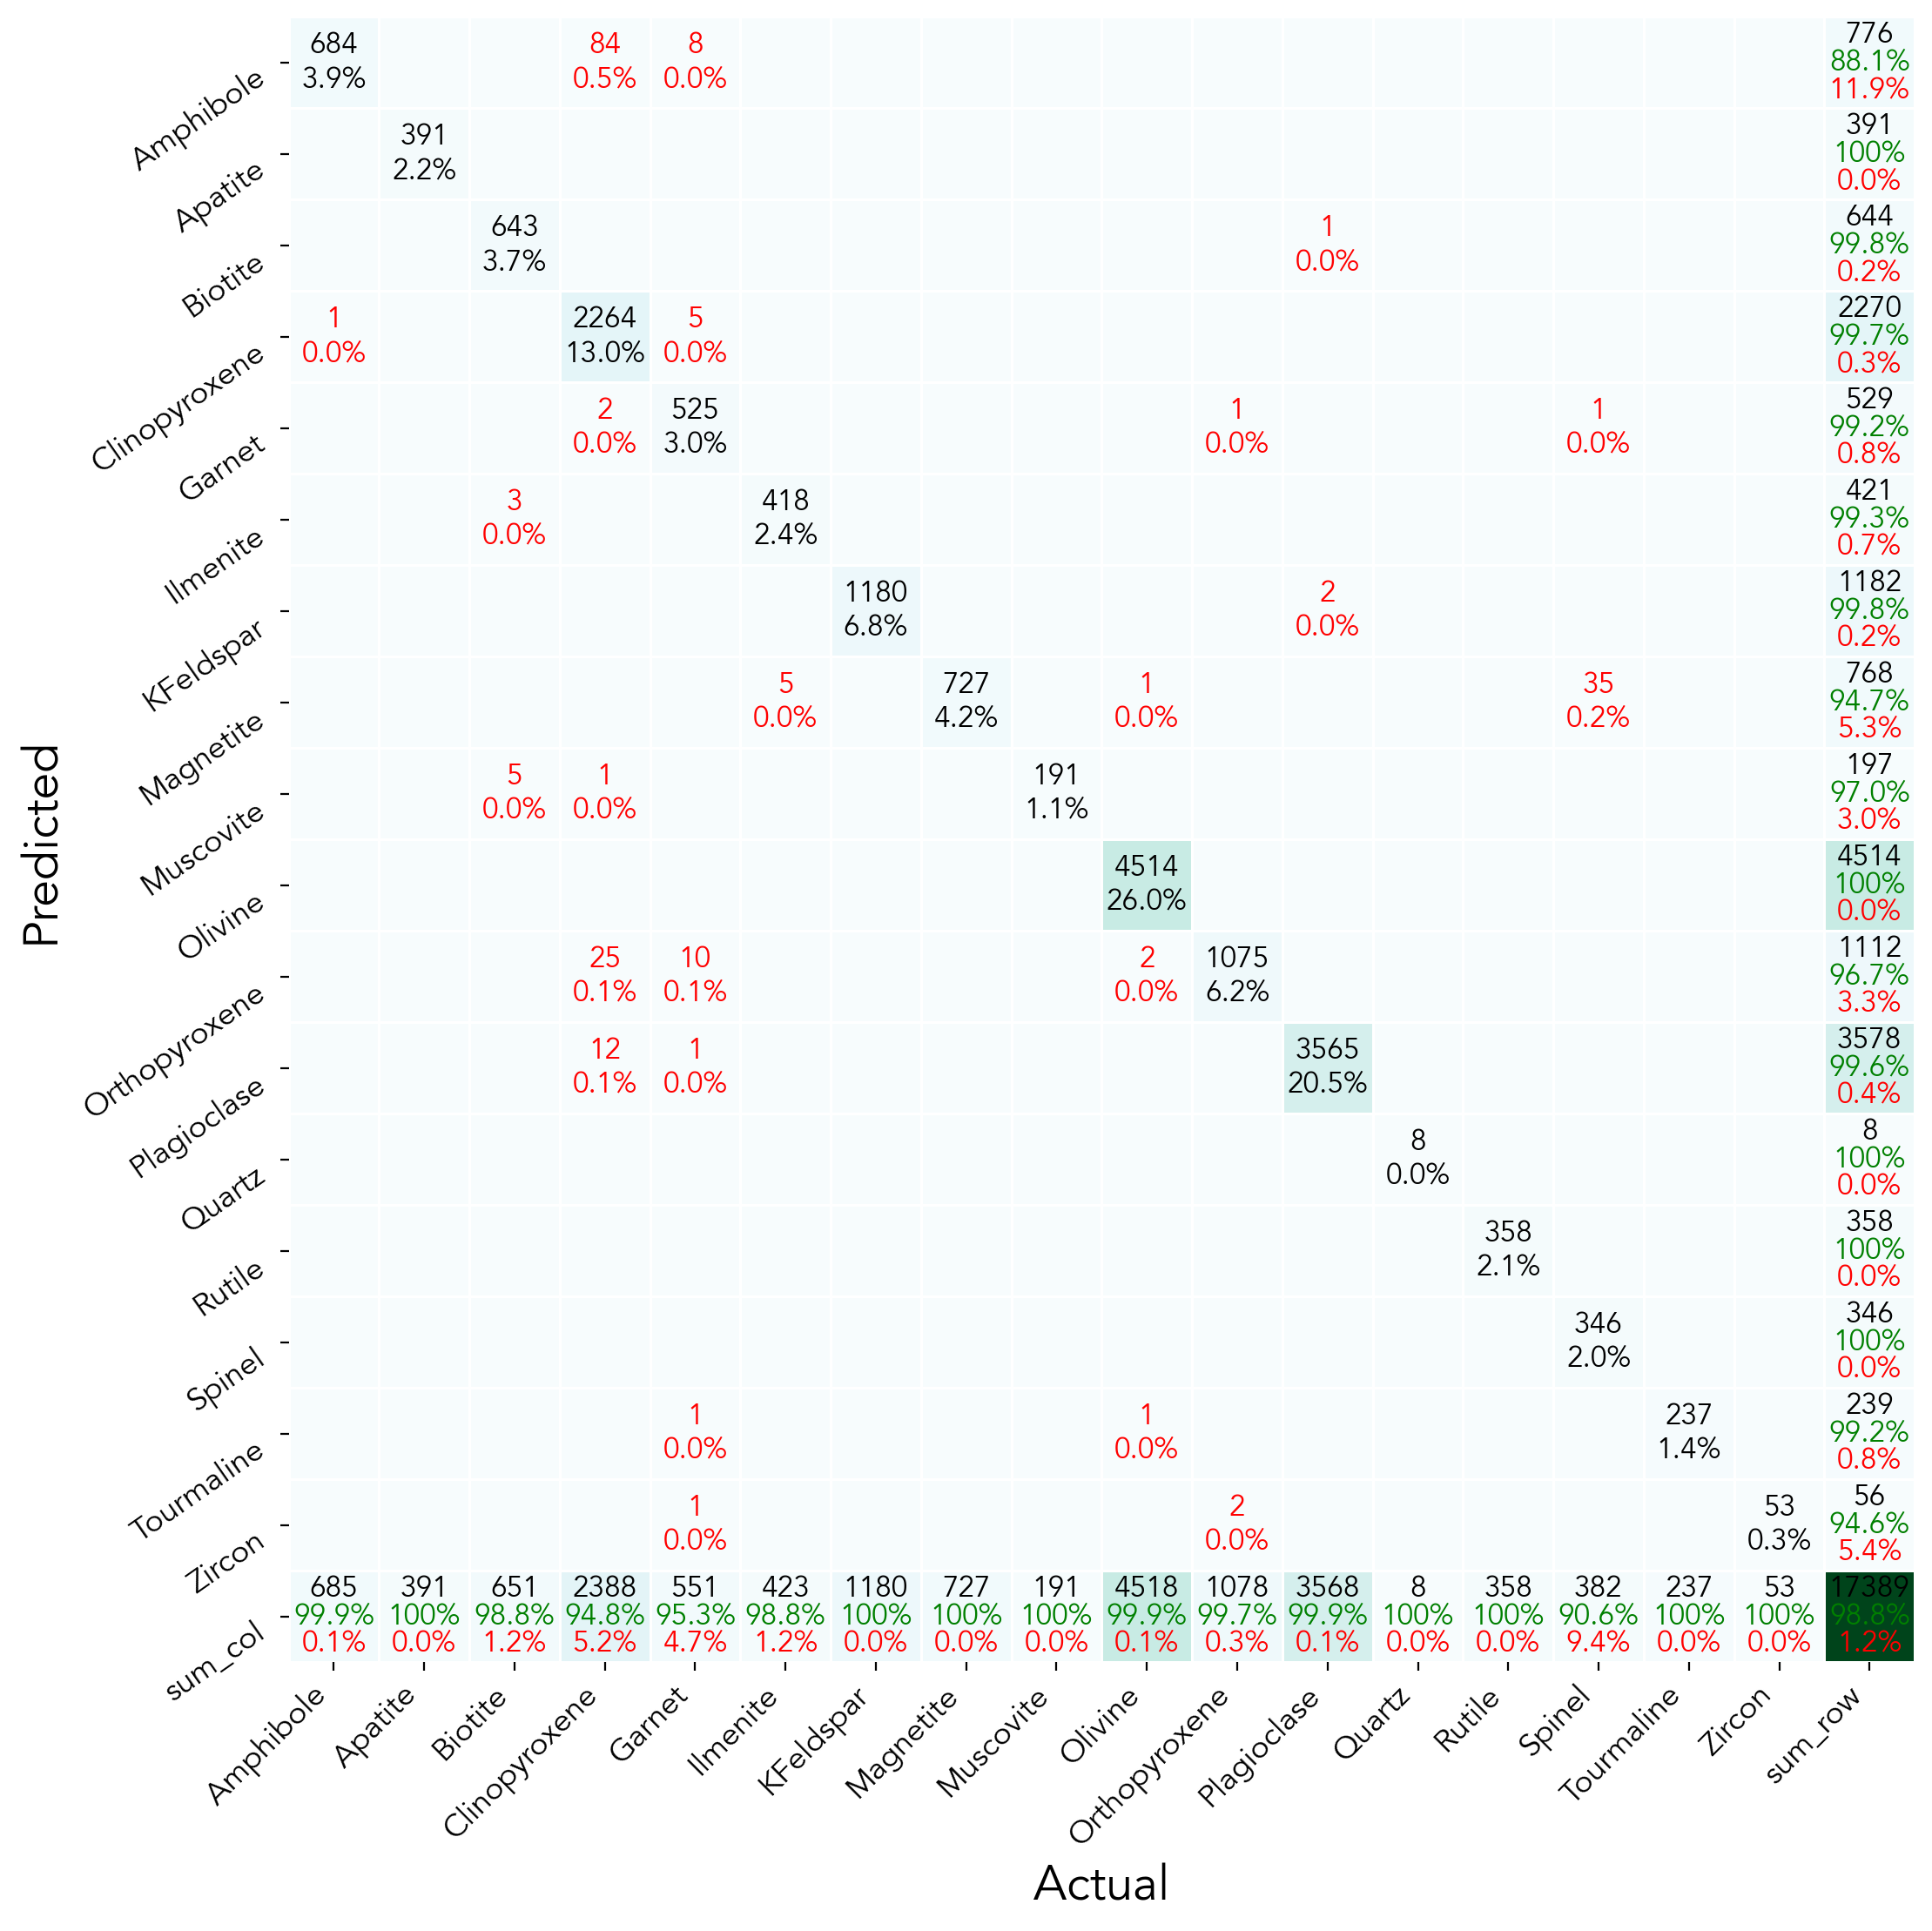

In [6]:
df_concat_wt = df_concat[oxides].fillna(0).to_numpy()
ss = StandardScaler()
array_norm_wt_new = ss.fit_transform(df_concat_wt)


train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(array_norm_wt_new, pd.Categorical(df_concat['Mineral']).codes, test_size=n, stratify = pd.Categorical(df_concat['Mineral']).codes, random_state=42)

# train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(array_norm, pd.Categorical(min_df['Mineral']).codes, test_size=n, stratify = pd.Categorical(min_df['Mineral']).codes, random_state=42)

train_data_x, train_data_y = mm.balance(train_data_x, train_data_y)

cm_train = confusion_matrix(train_data_y, train_pred_classes)
cm_test = confusion_matrix(test_data_y, test_pred_classes)

mapping = dict(zip(pd.Categorical(min_df['Mineral']).codes, pd.Categorical(min_df['Mineral'])))
sort_dictionary= dict(sorted(mapping.items(), key=lambda item: item[0])) 

df_train_cm = pd.DataFrame(cm_train, index=sort_dictionary.values(), columns=sort_dictionary.values())
cmap = 'BuGn'
mm.pp_matrix(df_train_cm, cmap = cmap, savefig = 'train', figsize = (11.5, 11.5)) 
plt.show()

df_test_cm = pd.DataFrame(cm_test, index=sort_dictionary.values(), columns=sort_dictionary.values())
mm.pp_matrix(df_test_cm, cmap = cmap, savefig = 'test', figsize = (11.5, 11.5))
plt.show()

<ipython-input-7-c6ba87c12361>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lepr_df_test['Mineral'] = lepr_df_test['Mineral'].astype(pd.CategoricalDtype(categories=min_df['Mineral'].cat.categories))
/Users/sarahcshi/Documents/GitHub/MIN_ML/src/MIN_ML/supervised.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740371165/work/torch/csrc/utils/tensor_numpy.cpp:205.)
 

New validation report:
                precision    recall  f1-score   support

    Amphibole       0.38      0.93      0.54       362
      Apatite       1.00      1.00      1.00        52
      Biotite       0.79      0.99      0.88       140
Clinopyroxene       0.99      0.66      0.79      2276
       Garnet       0.99      0.62      0.76      1012
     Ilmenite       0.00      0.00      0.00         0
    KFeldspar       0.61      0.77      0.68       118
    Magnetite       0.00      0.00      0.00         0
    Muscovite       0.00      0.00      0.00         8
      Olivine       1.00      0.99      0.99      1615
Orthopyroxene       0.81      0.97      0.88      1115
  Plagioclase       0.80      0.98      0.88      1171
       Quartz       0.43      1.00      0.60         3
       Rutile       0.10      1.00      0.19         5
       Spinel       1.00      0.63      0.77       955
   Tourmaline       0.00      0.00      0.00         0
       Zircon       0.38      1.00      

meta NOT subset; don't know how to subset; dropped


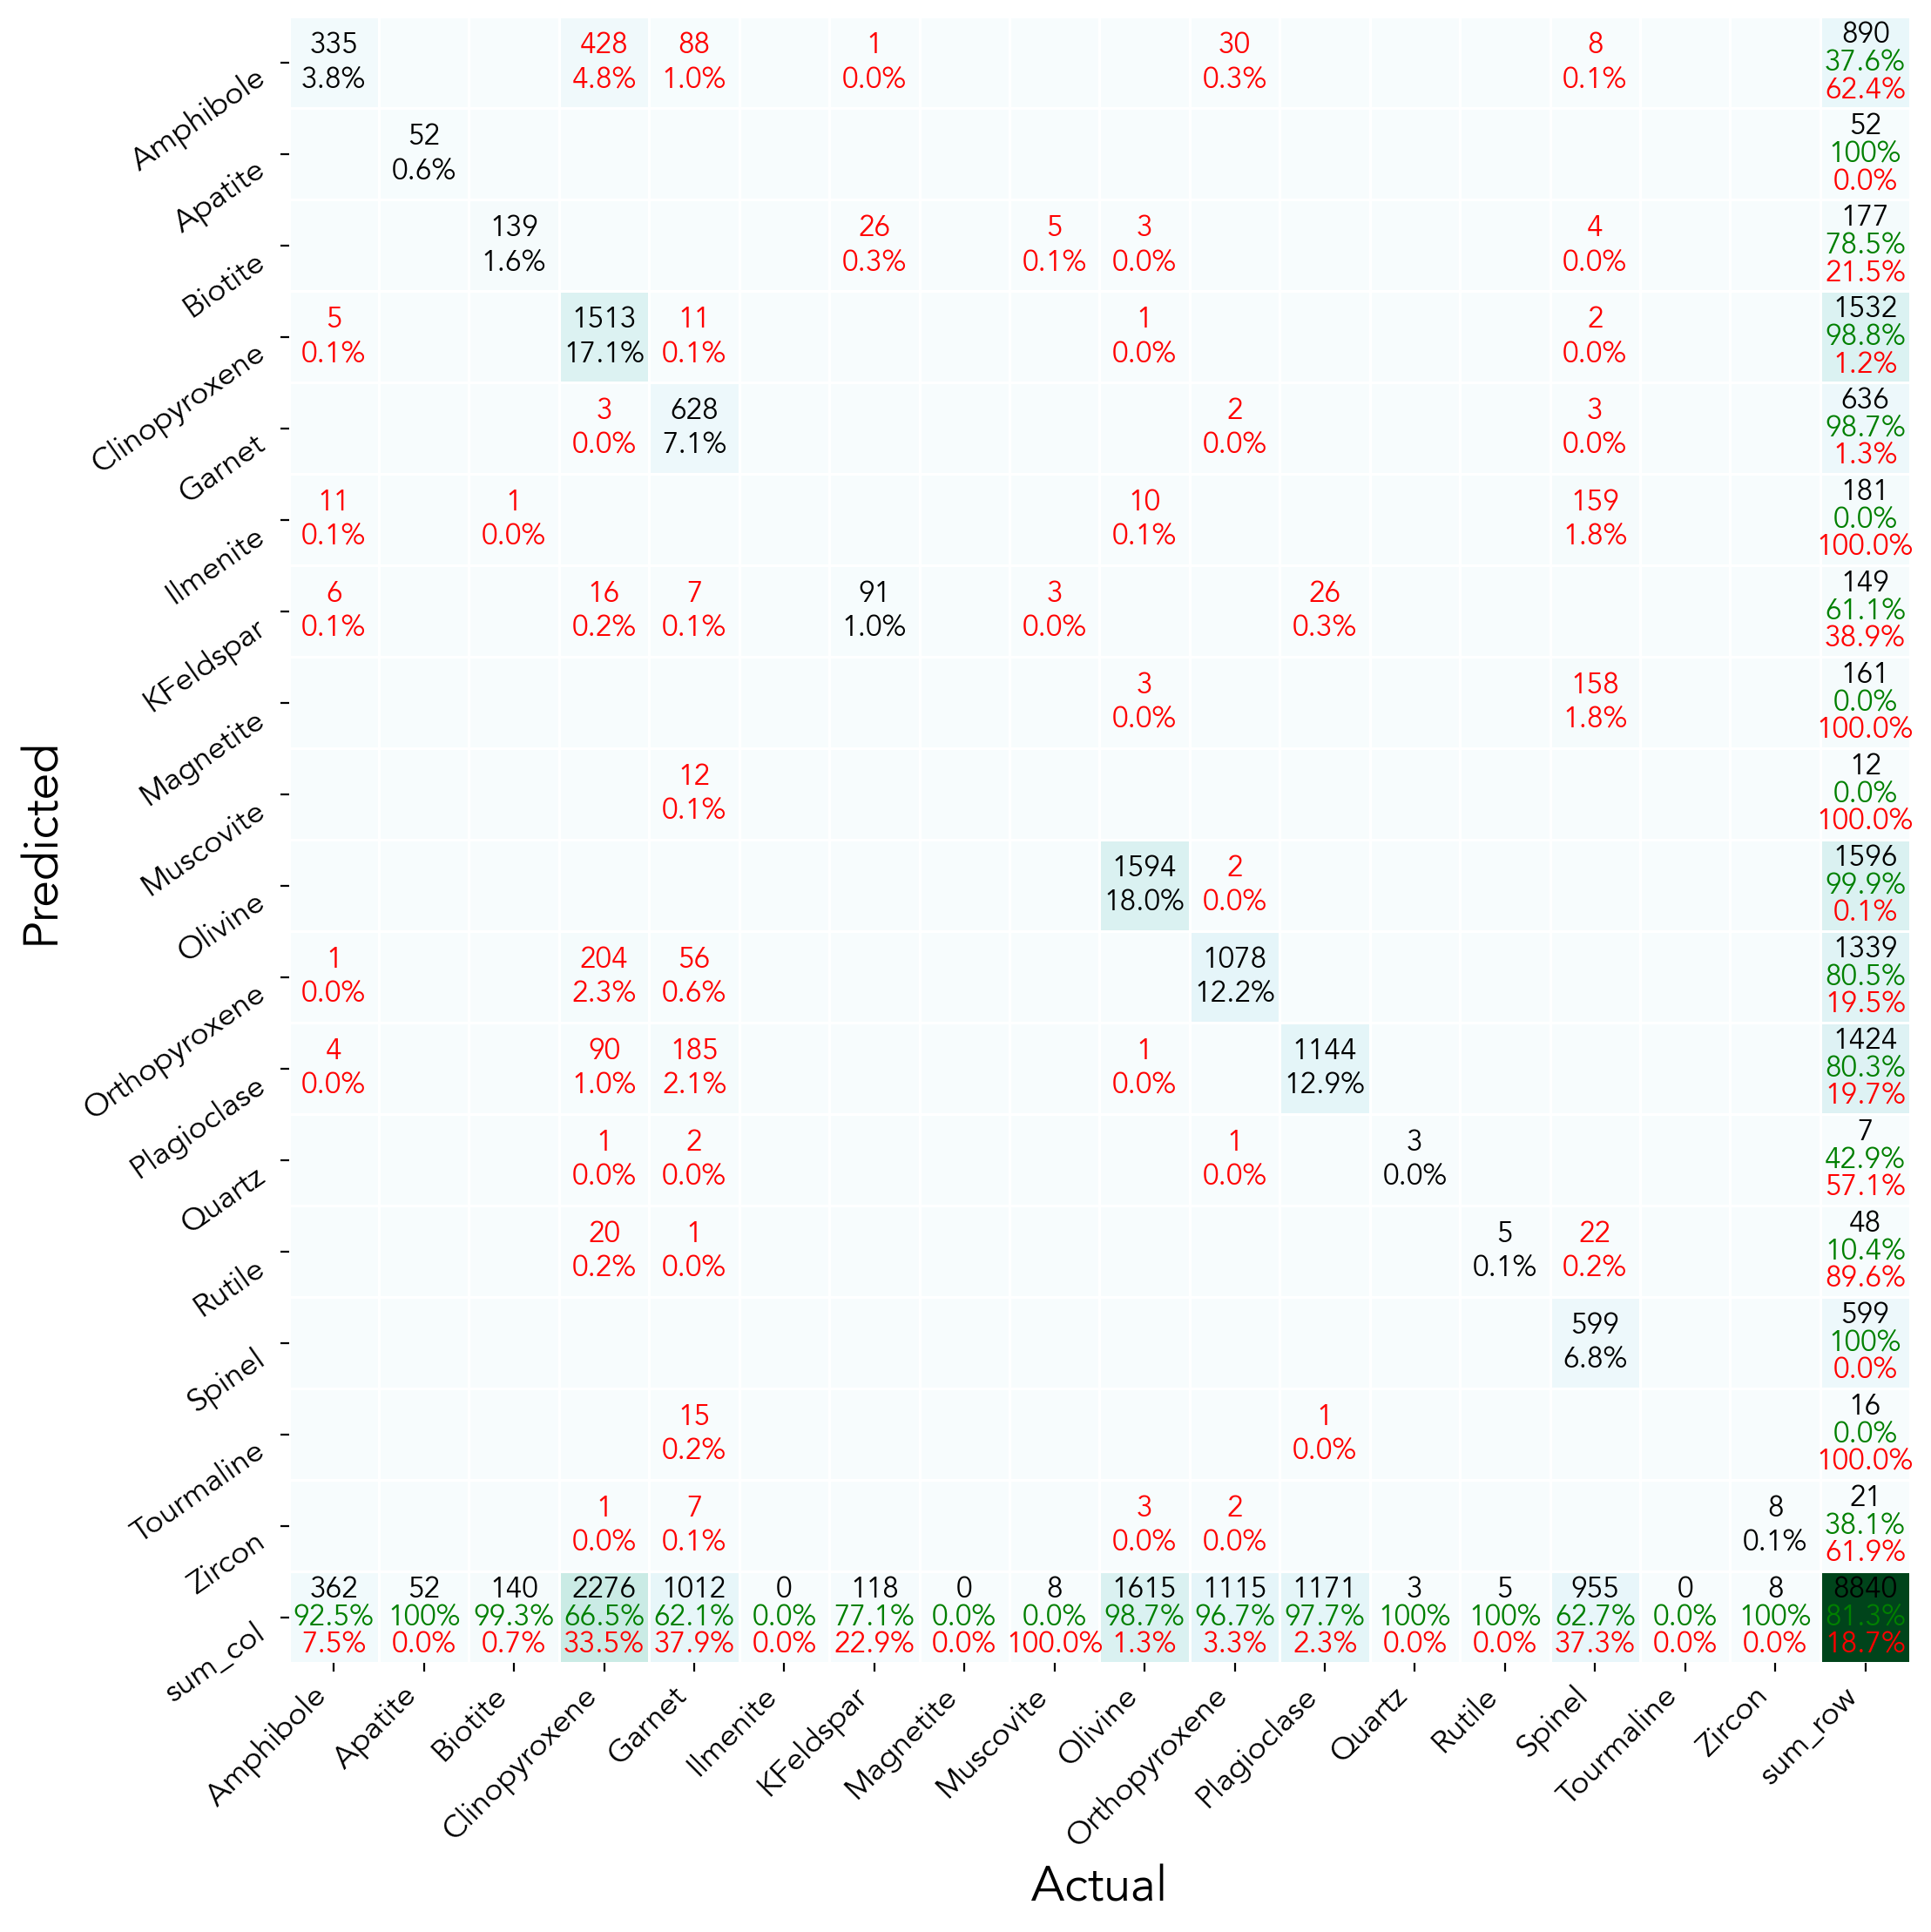

In [7]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
# lepr = pd.read_csv('Training_Data/mindf_filt.csv')

lepr = pd.read_csv('Validation_Data/lepr_allphases_lim.csv', index_col=0)
lepr_df = lepr.dropna(subset=oxides, thresh = 5)
lepr_df = lepr_df[(lepr_df.Mineral!=np.nan)&(lepr_df.Mineral!='FeTiOxide')]

data_idx = np.arange(len(lepr_df))
train_idx, test_idx = train_test_split(data_idx, test_size=0.3, stratify=pd.Categorical(lepr_df['Mineral']).codes, random_state=42, shuffle=True)
lepr_df_test = lepr_df.iloc[train_idx]


lepr_wt = lepr_df_test[oxides].fillna(0).to_numpy()
ss = StandardScaler()
lepr_norm_wt = ss.fit_transform(lepr_wt)






min_df['Mineral'] = min_df['Mineral'].astype('category')
lepr_df_test['Mineral'] = lepr_df_test['Mineral'].astype(pd.CategoricalDtype(categories=min_df['Mineral'].cat.categories))
new_validation_data_y = (lepr_df_test['Mineral'].cat.codes).values

# Create a DataLoader for the new validation dataset
new_validation_dataset = mm.LabelDataset(lepr_norm_wt, new_validation_data_y)
new_validation_loader = mm.DataLoader(new_validation_dataset, batch_size=256, shuffle=False)

input_size = len(new_validation_dataset.__getitem__(0)[0])

name = 'testing_best_nn'
path = 'nn_parametermatrix/' + name + '_nn_params.pt'

model = mm.MultiClassClassifier(input_dim=input_size, hidden_layer_sizes=hls, dropout_rate = dr).to(device) 
optimizer=torch.optim.SGD(model.parameters(), lr=lr, weight_decay = wd)

mm.load_model(model, optimizer, path)

# Use the trained model to predict the classes for the new validation dataset
model.eval()
new_validation_pred_classes = []
with torch.no_grad():
    for data, labels in new_validation_loader:
        x = data.to(device)
        pred_classes = model.predict(x)
        new_validation_pred_classes.extend(pred_classes.tolist())

new_validation_pred_classes = np.array(new_validation_pred_classes)
unique_classes = np.unique(np.concatenate((new_validation_data_y[new_validation_data_y != -1], new_validation_pred_classes[new_validation_data_y != -1])))

sort_mapping = {key: value for key, value in sorted(mapping.items(), key=lambda item: item[0]) if key in unique_classes}

# Calculate classification metrics for the new validation dataset
new_validation_report = classification_report(new_validation_data_y[new_validation_data_y!=-1], new_validation_pred_classes[new_validation_data_y!=-1], labels = unique_classes, target_names=[sort_mapping[x] for x in unique_classes], zero_division=0)
print("New validation report:\n", new_validation_report)

cm_valid = confusion_matrix(new_validation_data_y[new_validation_data_y!=-1], new_validation_pred_classes[new_validation_data_y!=-1])

df_valid_cm = pd.DataFrame(
    cm_valid,
    index=[sort_mapping[x] for x in unique_classes],
    columns=[sort_mapping[x] for x in unique_classes],
)

mm.pp_matrix(df_valid_cm, cmap = cmap, savefig = 'valid', figsize = (11.5, 11.5)) 